In [1]:
import sys
import os
from pathlib import Path
curr_dir = os.path.abspath('')
project_dir = Path(curr_dir).parent
sys.path.append(f"{project_dir}")
sys.path.append(f"{project_dir}/src")
sys.path

['/Users/albertinopadin/Desktop/Dev/Python Projects/PlaneRecognizer/notebooks',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python39.zip',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/lib-dynload',
 '',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages/IPython/extensions',
 '/Users/albertinopadin/.ipython',
 '/Users/albertinopadin/Desktop/Dev/Python Projects/PlaneRecognizer',
 '/Users/albertinopadin/Desktop/Dev/Python Projects/PlaneRecognizer/src']

In [2]:
# !pip install voila
# !jupyter serverextension enable voila --sys-prefix

In [3]:
from ImageObjectDetectors.TensorflowCNN4Images import TensorflowCNN4Images
from JetRecognizer.JetRecognizerPreprocessing import load_label_encoder, normalize_pixels_in_img_obj, convert_labels_to_one_hot_vectors, \
    get_random_validation_fighter_images_as_pixel_values_generator, get_random_test_fighter_images_as_pixel_values_generator
from time import perf_counter
from ImageObjectDetectors.CNN4ImagesBase import KernelProgression
from sklearn.metrics import precision_score, accuracy_score
from Common.DL_FilePaths import IMG_SIZE
import ipywidgets as widgets
from fastai.vision.all import *
# from PIL import Image

/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


physical_devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
INPUT_SHAPE = (960, 960, 3)
N_OUTPUT = 6
LEARNING_RATE = 0.001

# For Mac-trained model:
JET_RECOGNIZER_MODEL_FILENAME = 'jet_recognizer_apple_silicon' + '_' + str(INPUT_SHAPE[0])

# For Linux-trained model:
# JET_RECOGNIZER_MODEL_FILENAME = 'jet_recognizer_A6000' + '_' + str(INPUT_SHAPE[0])


LABEL_ENCODER_FILENAME = "jet_label_classes.npy"

# Still need to define the model, might want to refactor so don't have to...
jet_recognizer = TensorflowCNN4Images(INPUT_SHAPE,
                                      N_OUTPUT,
                                      LEARNING_RATE,
                                      kernel_progression=KernelProgression.KERNEL_GETS_BIGGER)

jet_recognizer.load_model(JET_RECOGNIZER_MODEL_FILENAME)
label_encoder = load_label_encoder(LABEL_ENCODER_FILENAME)

Using Kernel Progression: KernelProgression.KERNEL_GETS_BIGGER
TF Keras backend: <module 'keras.api._v2.keras.backend' from '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages/keras/api/_v2/keras/backend/__init__.py'>
Input Shape: (960, 960, 3)Metal device set to: Apple M1 Max

Model: "ImageCNN_TF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv64_input_layer (Conv2D)  (None, 480, 480, 64)     4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 240, 64)     0         
 )                                                               
                                                                 
 conv64_k5_layer (Conv2D)    (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                 

In [5]:
def preprocess_img(img, to_size=IMG_SIZE.IS_960):
    img.thumbnail((to_size.value, to_size.value))
    return pad_pil_image(img, to_size)

In [6]:
btn_upload = widgets.FileUpload()

out_pl = widgets.Output()
out_pl.clear_output()

lbl_pred = widgets.Label()

btn_run = widgets.Button(description='Classify')

In [7]:
# Adapted from fastai book p. 82:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    # img = Image.open(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
    # print(f'img shape: {img.shape}')
    normalized_img = normalize_pixels_in_img_obj(img)
    # print(f'normalized_img shape: {normalized_img.shape}')
    pred = jet_recognizer.predict(np.array([normalized_img]), flatten_output=False, one_hot=True)
    print(f'pred: {pred}')
    pred_label = label_encoder.inverse_transform(np.argmax(pred, axis=1))[0]
    print(f'Pred label: {pred_label}')
    lbl_pred.value = f'Prediction: {pred_label}'

In [8]:
btn_run.on_click(on_click_classify)

In [9]:
widgets.VBox([
    widgets.Label('Upload jet image'),
    btn_upload,
    btn_run,
    out_pl,
    lbl_pred
])

In [10]:
# fastai model:

In [11]:
from Common.DL_FilePaths import SIZE_960_DIR, FIGHTER_JET_SIZE_DIRS, IMG_SIZE, FIGHTER_JET
from ImagePreprocessing.ImagePreprocessing import get_file_paths_in_dir, JPG_EXT
from ImageObjectDetectors.FastaiSimpleModel import FastaiSimpleModel

In [12]:
def get_jet_filepaths_with_labels(size=IMG_SIZE.IS_960, subfolder='train'):
    filepaths = []
    labels = []
    for jet_type in FIGHTER_JET:
        jet_path = FIGHTER_JET_SIZE_DIRS.get(size).get(jet_type)
        train_path = jet_path + f'/{subfolder}'
        fps = get_file_paths_in_dir(train_path)
        for filepath in fps:
            if filepath.endswith(JPG_EXT):
                filepaths.append(filepath)
                labels.append(jet_type.name)

    return filepaths, labels

In [13]:
data_path = Path(SIZE_960_DIR)

In [14]:
JET_RECOGNIZER_MODEL_FILENAME = 'jet_recognizer_apple_silicon_960'

In [15]:
val_paths, val_labels = get_jet_filepaths_with_labels(subfolder='valid')
validation_dls = ImageDataLoaders.from_lists(data_path, val_paths, val_labels)

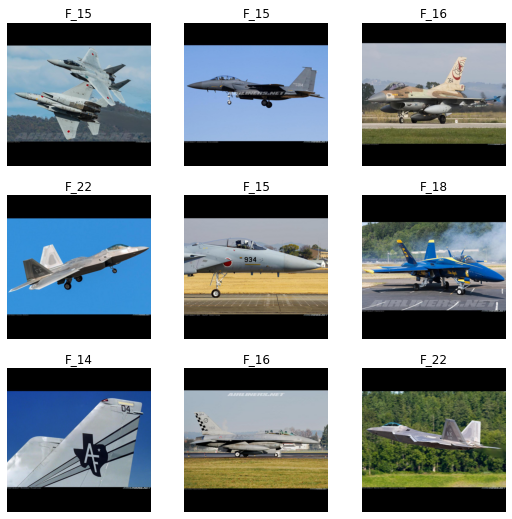

In [16]:
# validation_dls.one_batch()
validation_dls.show_batch()

In [17]:
jet_recognizer_fa = FastaiSimpleModel(validation_dls)

In [18]:
jet_recognizer_fa.load_model(JET_RECOGNIZER_MODEL_FILENAME)

In [19]:
btn_upload_fa = widgets.FileUpload()

out_pl_fa = widgets.Output()
out_pl_fa.clear_output()

lbl_pred_fa = widgets.Label()

btn_run_fa = widgets.Button(description='Classify')

In [20]:
# Adapted from fastai book p. 82:
def on_click_classify_fa(change):
    img = PILImage.create(btn_upload_fa.data[-1])
    out_pl_fa.clear_output()
    with out_pl_fa:
        display(img.to_thumb(128,128))
    pred = jet_recognizer_fa.predict(img)
    print(f'pred: {pred}')
    lbl_pred_fa.value = f'Prediction: {pred[0]}'

In [21]:
btn_run_fa.on_click(on_click_classify_fa)

In [22]:
widgets.VBox([
    widgets.Label('Upload jet image'),
    btn_upload_fa,
    btn_run_fa,
    out_pl_fa,
    lbl_pred_fa
])

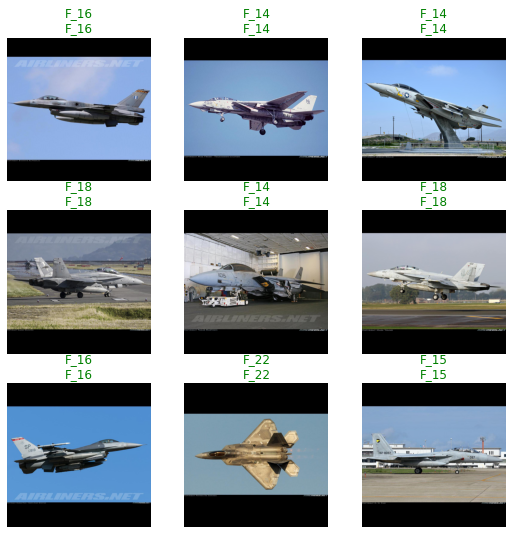

In [23]:
jet_recognizer_fa.model.show_results()